<div class="alert alert-block alert-info">
This script <b>queries PubChem database for (chemical) properties</b>.
    <hr> 
    Note: <br>
    <i><b>Input file(s)' name(s) and metadata</b></i> (if available) are <b>printed out (below 👇🏼) in 'read data to df' section.</b>
</div>

In [ ]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [ ]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import get_properties_from_pubchem
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel

%run init_nb.ipynb

# INPUTS: Identify file(s) and read data to df

In [ ]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

In [ ]:
# Read data
df_out = r_excel(inputs_dir, "raw-data-chosen-lcia-methods-and-metadata.xlsx")
df_out = df_out[["referenceProduct", "referenceProduct_casNumber"]].drop_duplicates()

In [ ]:
# if `pubchem-properties.xlsx` is in dir, read it, else, create empty df
try:
    df_properties_loaded = r_excel(inputs_dir, "pubchem-properties.xlsx")
    df_properties_comparison = df_properties_loaded[["referenceProduct", "referenceProduct_casNumber"]].drop_duplicates()
    print(
        "File with PubChem properties (`pubchem-propertiess.xlsx`) IS AVAILABLE in\n{}.\n"
        "\nThe file will be compared to `df_out` and the differences, i.e., the new activities,\n"
        "(if any) will be extracted from the PubChem database and added to the updated version of `df_properties`.".format(
            inputs_dir
        )
    )
except FileNotFoundError:
    print(
        "File with PubChem properties (`pubchem-propertiess.xlsx`) WAS NOT FOUND in\n{}.\n"
        "\nThe file will be generated by querying the PubChem database. "
        "This may be an expensive calculation step.".format(inputs_dir)
    )
    df_properties_comparison = pd.DataFrame(columns=["referenceProduct", "referenceProduct_casNumber"])

# Operations 
- query PubChem for data with chemical properties
<div class="alert alert-block alert-info">
    created: <code>df_properties</code> (based on the difference of unique items between <code>df_out</code> and <code>df_properties_comparison</code>)

## Preliminary manipulations

In [ ]:
df_out[df_out.referenceProduct == "Nylon 6-6"]

# for "Nylon 6-6" to be found in PubChem, CAS number has to be included
# (as found in cirpy, below).
# add CAS number "52349-42-5" to reference product "Nylon 6-6"
df_out.loc[
    df_out.referenceProduct == "Nylon 6-6", "referenceProduct_casNumber"
] = "52349-42-5"

df_out[df_out.referenceProduct == "Nylon 6-6"]

## Query PubChem database

In [ ]:
df_for_queries = (
    df_properties_comparison.merge(df_out, how="right", on=None, indicator=True)
    .query('_merge == "right_only"')
    .drop("_merge", 1)
)
print("{} product(s) will be queried from PubChem.".format(df_for_queries.shape[0]))
df_for_queries

<div class="alert alert-block alert-warning">
<strong class="alert-heading">WARNING ❗</strong> <br>
    This step may be <strong>time consuming</strong> due to the API restriction of PubChem database. <br>
</div>

In [ ]:
%%time

if df_for_queries.shape[0] > 0:  # if there are products to be queried
    df_properties = get_properties_from_pubchem(
        df_in=df_for_queries,
        cas_column="referenceProduct_casNumber",
        name_column="referenceProduct",
    )
    df_properties.reset_index(inplace=True)
    df_properties.rename(columns={"index": "referenceProduct"}, inplace=True)
else:
    df_properties = pd.DataFrame()

if df_properties_comparison.shape[0] > 0:
    df_properties = df_properties.append(df_properties_loaded, ignore_index=True)

Image of the first time query:
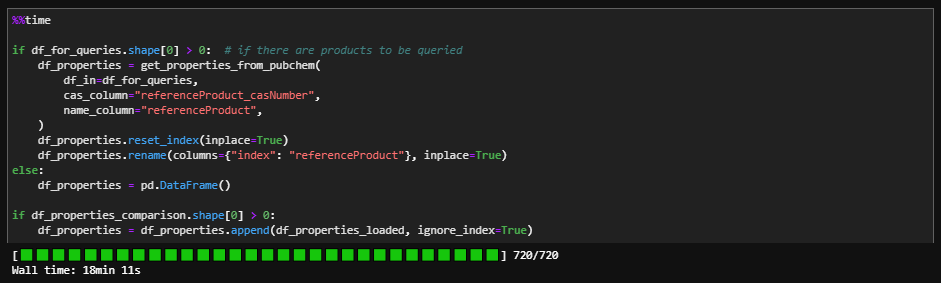

# OUTPUTS: Export data to excel

In [ ]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "pubchem-properties.xlsx"

df_readme = make_readme_info(
    excelName,
    "Dataframe with chemical properties for unique reference products from df_out. \n"
    "Chemical properties were retrieved from PubChem database.",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={"Sheet1": df_properties},
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)